# Classification Project: Predicting Cardiovascular Disease
***

**Author:** Ron Lodetti Jr.
![Heart](./images/heart.jpeg)

## Overview
***
This project uses machine learning and data from the CDC's [2021 Behavioral Risk Factor Surveillance System (BRFSS)](https://www.cdc.gov/brfss/annual_data/annual_2021.html) to help a hospital target patience who would benefit from an educational program about heart health. After model iteration and hyperparameter tuning, our final model can correctly predict 81% of people with a heart condition, while only incorrectly predicting 28% of negative cases as positive. 

## Business Problem
***
Cardiovascular diseases are the [leading cause of death](https://en.wikipedia.org/wiki/List_of_causes_of_death_by_rate) worldwide except Africa. A hospital wants to be able to identify patients who are at risk of Cardiovascular disease (CVD) to begin taking preventative measures as early as possible. The hospital has developed a new online educational program and would like to reccommend it to any patience at risk. 

## Data Understanding
***
This dataset, [from kaggle](https://www.kaggle.com/datasets/alphiree/cardiovascular-diseases-risk-prediction-dataset), is a cleaned version of the responses from the CDC's [2021 Behavioral Risk Factor Surveillance System (BRFSS)](https://www.cdc.gov/brfss/annual_data/annual_2021.html)





As you can see, we have 308,854 rows, each with 18 feature columns and 1 target column:

* `General_Health`: Respondent's reported general health
* `Checkup`: Time since respondent's last routine checkup
* `Exercise`: Participation in any physical activities or exercises in the past month
* `Heart_Disease`: **(Target)** Respondents that reported having coronary heart disease or myocardial infarction
* `Skin_Cancer`: Respondents that reported having skin cancer
* `Other_Cancer`: Respondents that reported having any other types of cancer
* `Depression`: Respondents that reported having a depressive disorder
* `Diabetes`: Respondents that reported having a diabetes
* `Arthritis`: Respondents that reported having an Arthritis
* `Sex`: Respondent's Gender
* `Age_Category`: Respondent's Age, by category
* `Height_(cm)`: Respondent's Height in centimeters
* `Weight_(kg)`: Respondent's Weight in kilograms
* `BMI`: Body Mass Index
* `Smoking_History`: Respondents that reported having a history of smoking cigarettes
* `Alcohol_Consumption`: Number of days, in the past 30 days, where respondent has had at least one alcoholic beverage
* `Fruit_Consumption`: Number of servings of fruit during the past 30 days
* `Green_Vegetables_Consumption`: Number of servings of vegetables during the past 30 days
* `FriedPotato_Consumption`: Number of servings of fruit during the past 30 days
![Heart](./images/viz_1.jpg)
![Heart](./images/viz_2.jpg)


Data Preparation?
***
The first step in our data preparation is to split the data in to test and train sets. We need to be careful to only use the test data as the last step in the evaluation process to avoid data leakage. 



#########################
I merged the original dataset with three other data sets from [King County Assessor Data](https://info.kingcounty.gov/assessor/DataDownload/default.aspx):

- Residential Building
- Parcel
- Real Property Sales

As well as a dataset from [OpenDataSoft](https://data.opendatasoft.com/) to gather information about King County zip codes.

Once merged, it consisted of 47,579 property sales, each containing information on 19 unique variables. 

<img src="./images/price.png">

## Data Modeling
***
Since our stakeholder wants to identify as many people as possible who could have a heart condition and the cost of a false positive (identifying a person as likely to have a heart condition when they will not) is low, then we should prioritize the true positive rate, or recall. Given the imbalance in our dataset, I will use the f2-score as my evaluation metric. This is a weighted harmonic mean between precision and recall which gives more weight to recall.

Additionally, I will use pipelines when cross-validating and scoring my data as to avoid data leakage. 

### Dummy Model
We will start with a dummy model which always predicts the most frequent target value. In this case it will predict everyone **does not** have a heart condition.

### Baseline Model

To choose a baseline model, I will first iterate through a couple modeling types and choose a baseline with the best metrics. 

Our GaussianNB model has a significantly higher f2-score (and recall) so we will choose that as our baseline. Note that the lower scores for accuracy, precision and roc_auc are ok given our stakeholders aims.

### Model Iteration

Next, I want to look two ensemble methods to help me which to use for our final model.

XGBClassifier has slightly better metrics. Additionally it ran much more quickly, which will be helpful when hypertuning.

Next, I want to try three different methods for handling our target imbalance and compare them to a basic model. 


The Weighted XGBClassifier siginicantly outperformed the others in both metrics and speed. 

#### Hyperparameter Tuning
I will start by using RandomizedSearchCV to randomly select parameters within ranges, scoring them, then searching for the parameters which produce the best f2-score. 

To save computation time I've pickled the results from the best model the search found. For more information, you can find the [code here.](./code/my_module.py)


Lastly, I will use these parameters and see if I can improve the f2-score by manipulating n_estimators, max_depth, and learning rate parameters and using GridSearchCV to score every combination of parameters from the options given. 

Once again, I've pickled the results from the best model the search found. For more information, you can find the [code here.](./code/my_module.py)

Grid searching helped improve metrics across the board. I will use this as the final model. 




## Evaluation
***
Now that we have found the final model, I will score each of our models on the test data. 

The final model was the best performing model on the test data, capturing almost 81% of all of the positive cases. Given the over 300,000 data entries, lack of data leakage, and cross-validation done during training, I'm confident that this model would generalize. 

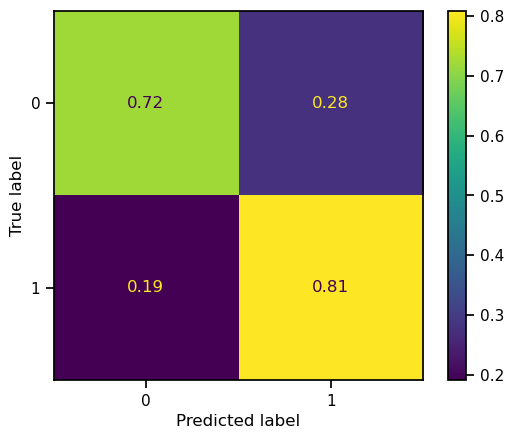

In [29]:
ConfusionMatrixDisplay.from_predictions(y_test, gs_model.predict(X_test), normalize='true');

Based on this confusion matrix our model would correctly predict 81% of positive cases and 72% of negative cases. It would incorrectly predict 28% of negative cases as positive and 19% of positive cases as negative. 

Next we can look at the ROC curve to view the relationship between the true positive rate and false positve rate across all classification thresholds. 

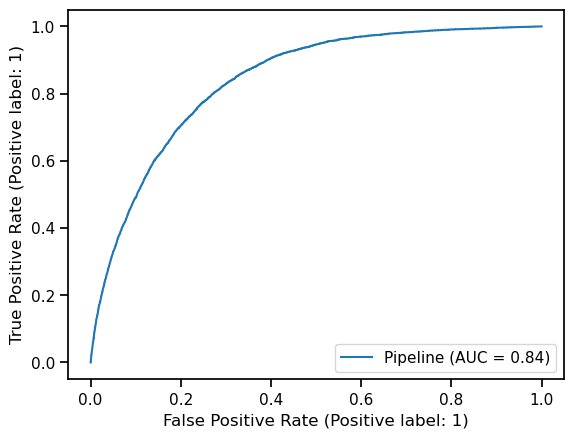

In [30]:
RocCurveDisplay.from_estimator(gs_model, X_test, y_test);

We may adjust the the classification threshold to meet the hospital's needs. 

For example, say we needed to correctly identify at least 90% of the positve cases. 

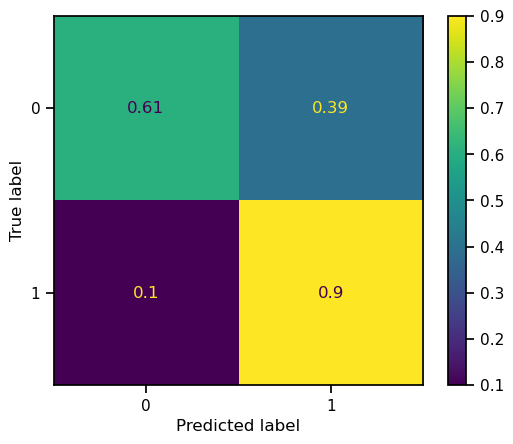

In [31]:
# setting classification threshold to 0.37
probabilities = gs_model.predict_proba(X_test)[:, 1]
new_threshold = 0.37
predicted_labels = (probabilities > new_threshold).astype(int)
ConfusionMatrixDisplay.from_predictions(y_test, predicted_labels, normalize='true');

Now we are correctly predicting 90% of positive cases. This change decreased the rate that we correctly identify negative cases from 72% to 61% and increased the rate of incorrectly predicting negative cases as positive from 28% to 39%.

## Conclusions

### Recommendations
- Based on our final model I would recommend that the hospital develop a questionaire to gather the appropriate information and to use the model to inform medical decisions. 
- Depending on the needs and resources of the hospital, we could adjust the classification threshold to increase our true positive rate or decrease our false positive rate. 

### Limitations
- This model would not be as helpful in cases where the cost of a positve identification is increased, such as recommending a more invasive procedure, medication, or otherwise more expenive or cumbersome consequence.  
- It may be difficult to get 18 pieces of data from a patient. 

### Next Steps
- It could be helpful to look at feature importance. Eliminating features in the model may make it easier for the hospital to collect data without sacrificing the model's performance. 
- It could also be helpful to research if there are other features which may help predict having a heart condition.

## For More Information

See the full analysis in the [Jupyter Notebook](./housing_project.ipynb) or review this [presentation](./housing_project_presentation.pdf).

For additional info, contact Ron Lodetti at [ron.lodetti@gmail.com](mailto:ron.lodetti@gmail.com)

## Repository Structure

```
├── code
│   ├── __init__.py
│   ├── data_modeling.py
│   ├── data_prep.py
│   └── data_visuals.py
├── data
├── images
├── README.md
├── requirements.txt
├── housing_project_presentation.pdf
└── housing_project.ipynb


```
